In [65]:
using Revise

In [66]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ

_μB = (μ_B / h) * 1e-4

include("CaOH_scan_helper_diffusion_v2.jl")
;

In [166]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end

temp = @with_unit 100 "μK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 

s2 = 0.0; Δ2 = 0.0; B_gradient = 75; ramp_time = 4e-3

detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)

intensity_voltage = 0.7
power_total = intensity_voltage * 13.1 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4

s = s1 + s3 + s4
# voltages = 0.3:0.2:2.1
# s_mult_scan = voltages * (34.6 / 3.4) /s
;

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,
                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                C3 = 0.0,
                                C5 = 0.0,
                                C7 = 0.0,
                                dt = 1e-2)

sequence = [blue_MOT_params]
durations = [5e-3]
generate_sequence!(sequence, durations);

In [115]:
@time results = simulate_particles_diffusion(package, package_A, sequence, variable_budget=true)
;

 29.698885 seconds (8.15 k allocations: 3.256 MiB)


In [167]:
prob_copy = make_problem_with_param_diffusion(package, package_A, blue_MOT_params)
p = prob_copy.p
dψ = deepcopy(p.ψ)
t=0.
ψ = p.ψ
;

In [120]:
n_states = length(p.states)
rescale_det = norm(det(p.U_t))^(1/n_states)

for i ∈ eachindex(p.U_t)
    p.U_t.re[i] /= rescale_det
    p.U_t.im[i] /= rescale_det
    p.U_t_dagger.re[i] /= rescale_det
    p.U_t_dagger.im[i] /= rescale_det
end

In [71]:
@btime ψ_stochastic_diffusion!($dψ, $ψ, $p, $t)

  6.080 μs (0 allocations: 0 bytes)


In [170]:
prob_copy = make_problem_with_param_diffusion(package, package_A, blue_MOT_params);
p = prob_copy.p;
dψ = deepcopy(p.ψ).*0
t=0.
ψ = p.ψ

cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
@time sol = DifferentialEquations.solve(prob_copy, alg=Euler(), callback=cb, saveat=100, maxiters=50000000, dt=3e-3)
;

 19.093161 seconds (1.33 k allocations: 781.891 KiB)


In [171]:
x(ψ) = real(ψ[21]) * (1/k) * 1e3
y(ψ) = real(ψ[22]) * (1/k) * 1e3
z(ψ) = real(ψ[23]) * (1/k) * 1e3
vx(ψ) = real(ψ[24]) * (Γ/k)
vy(ψ) = real(ψ[25]) * (Γ/k)
vz(ψ) = real(ψ[26]) * (Γ/k)
;

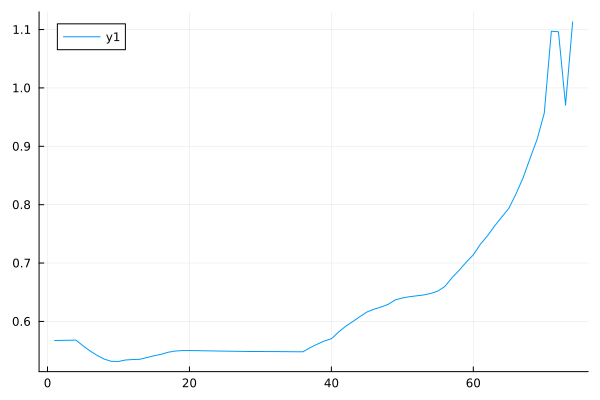

In [172]:
z.(sol.u) |> plot

In [77]:
function set_H_zero!(H)
    @turbo for i in eachindex(H)
        H.re[i] = 0.0
        H.im[i] = 0.0
    end
    return nothing
end

struct Jump
    s ::Int64
    s′::Int64
    q::Int64
    r ::ComplexF64
end

function base_to_soa!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ_soa)
        ρ_soa.re[i] = real(ρ[i])
        ρ_soa.im[i] = imag(ρ[i])
    end
    return nothing
end

function update_eiωt!(eiωt::StructArray{<:Complex}, ω::Array{<:Real}, τ::Real)
    @turbo for i ∈ eachindex(ω)
        eiωt.im[i], eiωt.re[i] = sincos( ω[i] * τ )
    end
    
    return nothing
end

function force_stochastic(E_k, ds, ds_state1, ds_state2, ψ_soa, eiωt)
    F = @SVector Complex{Float64}[0,0,0]

    @inbounds @fastmath for q ∈ 1:3
        ds_q = ds[q]
        ds_q_re = ds_q.re
        ds_q_im = ds_q.im
        ds_state1_q = ds_state1[q]
        ds_state2_q = ds_state2[q]
        for k ∈ 1:3
            E_kq = E_k[k][q]
            E_kq_re = real(E_kq)
            E_kq_im = imag(E_kq)
            F_k_re = 0.0
            F_k_im = 0.0
            for j ∈ eachindex(ds_q)
                m = ds_state1_q[j] # excited state
                n = ds_state2_q[j] # ground state
                
                # construct ρ_mn = c_m c_n^*
                # ρ_mn = conj(ψ_soa[n]*eiωt[n]) * ψ_soa[m]*eiωt[m]

                c_m = ψ_soa[m] * conj(eiωt[m]) # exp(-iωt) factor to transform to Heisenberg picture
                c_n = ψ_soa[n] * conj(eiωt[n]) # exp(-iωt) factor to transform to Heisenberg picture

                ρ_mn = c_m * conj(c_n)

                ρ_re = real(ρ_mn)
                ρ_im = imag(ρ_mn)
                
                d_re = ds_q_re[j]
                d_im = ds_q_im[j]

                a1 = d_re * ρ_re - d_im * ρ_im
                a2 = d_re * ρ_im + d_im * ρ_re
                F_k_re += E_kq_re * a1 - E_kq_im * a2
                F_k_im += E_kq_im * a1 + E_kq_re * a2     
            end
            F -= (im * F_k_re - F_k_im) * ê[k] # multiply by im
        end
    end
    F += conj(F)

    return real.(F)
end

function mul_by_im_minus!(C::StructArray{<:Complex})
    @turbo for i ∈ eachindex(C)
        a = C.re[i]
        C.re[i] = C.im[i]
        C.im[i] = -a
    end
end

function soa_to_base!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ_soa)
        ρ[i] = ρ_soa.re[i] + im * ρ_soa.im[i]
    end
    return nothing
end


soa_to_base! (generic function with 1 method)

In [78]:
function update_H_dipole!(p, τ,r, fields, H, E_k, ds, ds_state1, ds_state2, Js)
    # unpack some variables from p
    
    # reset the matrices
    set_H_zero!(H)
    set_H_zero!(p.∇H_x)
    set_H_zero!(p.∇H_y)
    set_H_zero!(p.∇H_z)


    # Reset total E field and E dot k to zero
    p.E -= p.E
    @inbounds @fastmath for i ∈ 1:3
        E_k[i] -= E_k[i]
    end
    
    # update each laser at the current time and position
    update_fields!(fields, r, τ)
    
    # Calculate total E field and total E dot k
    @inbounds @simd for i ∈ eachindex(fields)
        E_i = fields.E[i] * sqrt(fields.s[i]) / (2 * √2)
        k_i = fields.k[i]
        p.E += E_i
        for k ∈ 1:3
            E_k[k] += E_i * k_i[k]
        end
    end

    # calculate dipole Hamiltonian matrix elements
    @inbounds @fastmath for q ∈ 1:3
        E_q = p.E[q]
        E_q_re = real(E_q)
        E_q_im = imag(E_q)
        ds_q = ds[q]
        ds_q_re = ds_q.re
        ds_q_im = ds_q.im
        ds_state1_q = ds_state1[q]
        ds_state2_q = ds_state2[q]
        for i ∈ eachindex(ds_q)
            m = ds_state1_q[i] # excited state
            n = ds_state2_q[i] # ground state
            d_re = ds_q_re[i]
            d_im = ds_q_im[i]
            val_re = E_q_re * d_re - E_q_im * d_im
            val_im = E_q_re * d_im + E_q_im * d_re
            H.re[n,m] += -val_re # minus sign to make sure Hamiltonian is -d⋅E
            H.im[n,m] += -val_im
            H.re[m,n] += -val_re
            H.im[m,n] -= -val_im
        end
    end

    # add the anti-Hermitian term
    @inbounds @fastmath for J ∈ Js
        H.im[J.s, J.s] -= J.r # note that this is different from OBE calcs because we already converted to J.r = Γ^2/2
    end
    
    
    # calculate matrix elements of the gradient of the dipole Hamiltonian
    
    calculate_grad_H!(p.∇H_x, 1, p, E_k, ds, ds_state1, ds_state2)
    calculate_grad_H!(p.∇H_y, 2, p, E_k, ds, ds_state1, ds_state2)
    calculate_grad_H!(p.∇H_z, 3, p, E_k, ds, ds_state1, ds_state2)

    return nothing
end


function calculate_grad_H!(∇H_k, k, p, E_k, ds, ds_state1, ds_state2)
    @inbounds @fastmath for q ∈ 1:3
        E_kq =  -im * E_k[k][q] # E_kq = im * sum_{field i} (wave vector i in direction k) * (E field i in spherical component q)
        E_kq_re = real(E_kq)
        E_kq_im = imag(E_kq)
        ds_q = ds[q]
        ds_q_re = ds_q.re
        ds_q_im = ds_q.im
        ds_state1_q = ds_state1[q]
        ds_state2_q = ds_state2[q]
        
        for i ∈ eachindex(ds_q)
            m = ds_state1_q[i] # excited state
            n = ds_state2_q[i] # ground state
            d_re = ds_q_re[i]
            d_im = ds_q_im[i]
            val_re = E_kq_re * d_re - E_kq_im * d_im
            val_im = E_kq_re * d_im + E_kq_im * d_re
            ∇H_k.re[n,m] += -val_re # minus sign to make sure Hamiltonian is -d⋅E
            ∇H_k.im[n,m] += -val_im
            ∇H_k.re[m,n] += -val_re
            ∇H_k.im[m,n] -= -val_im
        end
        
    end
    
end

calculate_grad_H! (generic function with 1 method)

In [79]:
function schrodinger_stochastic_diffusion(
    particle, states, fields, d, ψ₀, mass, n_excited;
    sim_params=nothing, extra_data=nothing, λ=1.0, Γ=2π, update_H_and_∇H=update_H_and_∇H)
    """
    extra_p should contain n_excited
    
    ψ in the output will be of the following format:
    the first n_states indicies will be the coefficients of the current state;
    the next n_excited indicies is the time-integrated excited state population (reset by callbacks);
    the next 3 indicies are the current position;
    the next 3 indicies are the current velocity;
    the last 3 indicies are the current force.
    """
    dt = sim_params.dt
    
    n_states = length(states)
    n_fields = length(fields)

    states = StructArray(states)
    fields = StructArray(fields)

    k = 2π / λ
    
    # time unit: 1/Γ
    for i ∈ eachindex(fields)
        fields.ω[i] /= Γ
    end
    for i ∈ eachindex(states)
        states.E[i] *= 2π
        states.E[i] /= Γ
    end

    r0 = particle.r0
    r = particle.r
    v = particle.v

    type_complex = ComplexF64

    H = StructArray( zeros(type_complex, n_states, n_states) ) # light-molecule (dipole) Hamiltonian
    H₀ = deepcopy(H) # Zeeman and ODT Hamiltonian
    U_t = deepcopy(H) # time-evolution operator
    for i in 1:n_states
        U_t[i,i] = 1.0
    end
    P_x = StructArray( zeros(type_complex, n_states, n_states) ) # momentum operator
    Px_sq = StructArray( zeros(type_complex, n_states, n_states) ) # momentum operator squared
    P_y = StructArray( zeros(type_complex, n_states, n_states) ) # momentum operator
    Py_sq = StructArray( zeros(type_complex, n_states, n_states) ) # momentum operator squared
    P_z = StructArray( zeros(type_complex, n_states, n_states) ) # momentum operator
    Pz_sq = StructArray( zeros(type_complex, n_states, n_states) ) # momentum operator squared
    for i in 1:n_states
       P_x[i,i] = v[1]*mass
        P_y[i,i] = v[2]*mass
        P_z[i,i] = v[3]*mass
        Px_sq[i,i] = (v[1]*mass)^2
        Py_sq[i,i] = (v[2]*mass)^2
        Pz_sq[i,i] = (v[3]*mass)^2
    end
    
    mat_aux = deepcopy(H) # an auxiliary matrix
    

    ∇H_x = deepcopy(H) # gradient of dipole Hamiltonian (operator!)
    ∇H_y = deepcopy(H)
    ∇H_z = deepcopy(H)
    
    ∇H = SVector{3, ComplexF64}(0,0,0) # gradient of the ODT Hamiltonian = ∇H * H_ODT. ∇H is just a 3-vector

    ω = [s.E for s in states]
    eiωt = StructArray(zeros(type_complex, n_states))
    U0_dt = deepcopy(H)
    for i in 1:n_states
        U0_dt[i,i] = exp(-im*dt*ω[i])
    end
    

    # Compute cartesian indices to indicate nonzero transition dipole moments in `d`
    # Indices below the diagonal of the Hamiltonian are removed, since those are defined via taking the conjugate
    d_nnz_m = [cart_idx for cart_idx ∈ findall(d[:,:,1] .!= 0) if cart_idx[2] >= cart_idx[1]]
    d_nnz_0 = [cart_idx for cart_idx ∈ findall(d[:,:,2] .!= 0) if cart_idx[2] >= cart_idx[1]]
    d_nnz_p = [cart_idx for cart_idx ∈ findall(d[:,:,3] .!= 0) if cart_idx[2] >= cart_idx[1]]
    d_nnz = [d_nnz_m, d_nnz_0, d_nnz_p]

    Js = Array{Jump}(undef, 0)
    ds = [Complex{Float64}[], Complex{Float64}[], Complex{Float64}[]]
    ds_state1 = [Int64[], Int64[], Int64[]]
    ds_state2 = [Int64[], Int64[], Int64[]]
    for s′ in eachindex(states), s in s′:n_states, q in qs
        dme = d[s′, s, q+2]
        if abs(dme) > 1e-10 && (states[s′].E < states[s].E) # only energy-allowed jumps are generated
        # if (states[s′].E < states[s].E) # only energy-allowed jumps are generated
            push!(ds_state1[q+2], s)
            push!(ds_state2[q+2], s′)
            push!(ds[q+2], dme)
            rate = norm(dme)^2 / 2
            J = Jump(s, s′, q, rate)
            push!(Js, J)
        end
    end
    ds = [StructArray(ds[1]), StructArray(ds[2]), StructArray(ds[3])]
    
    ψ_soa = StructArray(ψ₀)
    dψ_soa = StructArray(ψ₀)
    
    # ψ contains the state vector, accumulated excited state populations, position, velocity, force
    ψ = zeros(ComplexF64, n_states + n_excited + 3 + 3 + 3)
    ψ[1:n_states] .= ψ₀
    ψ[n_states + n_excited + 1: n_states + n_excited + 3] .= r
    ψ[n_states + n_excited + 4: n_states + n_excited + 6] .= v
    dψ = deepcopy(ψ)

    E = @SVector Complex{Float64}[0,0,0]
    E_k = [@SVector Complex{Float64}[0,0,0] for _ ∈ 1:3]

    decay_dist = Exponential(1)

    # NOTE: mass with correct unit = dimensionless mass here * hbar * k^2 / Γ
    p = MutableNamedTuple(
        H=H, H₀=H₀, ∇H=∇H, ψ=ψ, dψ=dψ, ψ_soa=ψ_soa, dψ_soa=dψ_soa, ω=ω, eiωt=eiωt, Js=Js,
        states=states, fields=fields, r0=r0, r=r, v=v, d=d, d_nnz=d_nnz, 
        λ=λ, k=k, Γ=Γ,
        E=E, E_k=E_k,
        ds=ds, ds_state1=ds_state1, ds_state2=ds_state2,
        sim_params=sim_params, extra_data=extra_data, mass = mass, update_H_and_∇H=update_H_and_∇H, populations = zeros(Float64, n_states),
        n_scatters = 0,
        save_counter=0,
        n_states=length(states),
        n_ground=length(states) - n_excited,
        n_excited=n_excited,
        trajectory=Vector{ComplexF64}[],
        decay_dist=decay_dist,
        time_to_decay=rand(decay_dist),
        ∇H_x = ∇H_x, ∇H_y = ∇H_y, ∇H_z = ∇H_z,
        U_t = U_t, U_t_dagger = deepcopy(U_t), 
        P_x = P_x, P_y = P_y, P_z = P_z, 
        Px_sq = Px_sq, Py_sq =Py_sq, Pz_sq = Pz_sq,
        mat_aux = mat_aux,
        mat_aux1 = deepcopy(mat_aux),
        mat_aux2 = deepcopy(mat_aux),
        ψ_prev = deepcopy(ψ_soa),
        U0_dt = U0_dt,
        dt = sim_params.dt
        )

    return p
end

schrodinger_stochastic_diffusion (generic function with 1 method)

In [80]:
function update_evolution_operator!(p)
    """ Update p.U_t and p.U_t_dagger. 
    This must be called after p.H is updated, and before transforming p.H to interaction picture.
    """
    dt = p.dt
    
    
    # evolution operator of this step U_dt = 1 - i H dt
    # p.mat_aux1 will be set to U_dt
    reset_operator_diagonal!(p.mat_aux1, 1.0+0*im)
    for i ∈ eachindex(p.mat_aux1)
        p.mat_aux1.im[i] += -1 * p.H.re[i] * dt
#         p.mat_aux1.re[i] +=  p.H.im[i] * dt
    end
    
    mul_turbo!(p.mat_aux, p.mat_aux1, p.U0_dt)
    mul_turbo!(p.mat_aux2, p.mat_aux, p.U_t)
    
    for i ∈ eachindex(p.U_t)
        p.U_t.re[i] = p.mat_aux2.re[i]
        p.U_t.im[i] = p.mat_aux2.im[i]
    end
    
    # evolution operator of this step U_dt_dagger = 1 + i H dt
    # p.mat_aux1 will be set to U_dt_dagger
     reset_operator_diagonal!(p.mat_aux1, 1.0+0*im)
    for i ∈ eachindex(p.mat_aux1)
        p.mat_aux1.im[i] += 1 * p.H.re[i] * dt
#         p.mat_aux1.re[i] += p.H.im[i] * dt
    end
    
    mul_turbo_conjA!(p.mat_aux, p.U0_dt, p.mat_aux1)
    mul_turbo!(p.mat_aux2, p.U_t_dagger, p.mat_aux)
    
    set_H_zero!(p.U_t_dagger)
    
    for i ∈ eachindex(p.U_t)
        p.U_t_dagger.re[i] += p.mat_aux2.re[i]
        p.U_t_dagger.im[i] += p.mat_aux2.im[i]
    end  
    
    # normalize the determinant of U and U dagger
#     n_states = length(p.states)
#     rescale_det = norm(det(p.U_t))^(1/n_states)
    
#     for i ∈ eachindex(p.U_t)
#         p.U_t.re[i] /= rescale_det
#         p.U_t.im[i] /= rescale_det
#         p.U_t_dagger.re[i] /= rescale_det
#         p.U_t_dagger.im[i] /= rescale_det
#     end
    
end

update_evolution_operator! (generic function with 1 method)

In [81]:
function SE_collapse_pol_diffusion!(integrator)

    p = integrator.p
    n_states = p.n_states
    n_excited = p.n_excited
    n_ground = p.n_ground
    d = p.d
    ψ = integrator.u
    
    # A photon is observed.
    # Measure the polarization of the photon along z.
    p⁺ = 0.0
    p⁰ = 0.0
    p⁻ = 0.0
    
    for i ∈ 1:n_excited
        ψ_pop = norm(ψ[n_ground + i])^2
        for j ∈ 1:n_ground
            p⁺ += ψ_pop * norm(d[j,n_ground+i,1])^2
            p⁰ += ψ_pop * norm(d[j,n_ground+i,2])^2
            p⁻ += ψ_pop * norm(d[j,n_ground+i,3])^2
        end
        # note the polarization p in d[:,:,p] is defined to be m_e - m_g, 
        # whereas the polarization of the emitted photon is m_g - m_e
    end
    
    p_norm = p⁺ + p⁰ + p⁻
    rn = rand() * p_norm
    for i ∈ 1:n_ground
        ψ[i] = 0.0
    end
    
    pol = 0
    if 0 < rn <= p⁺ # photon is measured to have polarization σ⁺
        pol = 1
    elseif p⁺ < rn <= p⁺ + p⁰ # photon is measured to have polarization σ⁰
        pol = 2
    else # photon is measured to have polarization σ⁻
        pol = 3
    end
    
    for i in 1:n_ground
        for j in (n_ground+1):n_states
            ψ[i] += ψ[j] * d[i,j,pol]
        end
    end
    
    # zero excited state amplitudes
    for i ∈ (n_ground + 1):n_states
        ψ[i] = 0.0
    end
    
    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    p.n_scatters += 1
    
    # zero excited state populations
    for i ∈ (n_states+1):(n_states+n_excited)
        integrator.u[i] = 0.0
    end

     # reset excited state population accumulation
    # integrator.u[n_states + 1:n_states + n_excited] .= 0
    
#     for i in 1:n_states
#         integrator.p.populations[i] = norm(integrator.u[i])^2
#     end
    
#     println(p.P_x)
#     println("collapse!")
    
    # convert P from Schrodinger picture to Heisenberg picture
    mul_turbo!(p.mat_aux, p.U_t, p.P_x)
    mul_turbo!(p.P_x, p.U_t_dagger, p.mat_aux)
    mul_turbo!(p.mat_aux, p.U_t, p.P_y)
    mul_turbo!(p.P_y, p.U_t_dagger, p.mat_aux)
    mul_turbo!(p.mat_aux, p.U_t, p.P_z)
    mul_turbo!(p.P_z, p.U_t_dagger, p.mat_aux)
    
    mul_turbo!(p.Px_sq, p.P_x, p.P_x)
    mul_turbo!(p.Py_sq, p.P_y, p.P_y)
    mul_turbo!(p.Pz_sq, p.P_z, p.P_z)
    
    σ_px = operator_matrix_expectation_complex(p.Px_sq, p.ψ_prev)[1] - ((operator_matrix_expectation_complex(p.P_x, p.ψ_prev)[1]))^2 
    σ_py = operator_matrix_expectation_complex(p.Py_sq, p.ψ_prev)[1] - ((operator_matrix_expectation_complex(p.P_y, p.ψ_prev)[1]))^2
    σ_pz = operator_matrix_expectation_complex(p.Pz_sq, p.ψ_prev)[1] - ((operator_matrix_expectation_complex(p.P_z, p.ψ_prev)[1]))^2
    
#     println((operator_matrix_expectation_complex(p.P_x, p.ψ_prev)[1])/p.mass)
#     println(integrator.u[n_states + n_excited + 4])
#     # println(sqrt(abs(σ_px)))
#     println()
    
#     println((operator_matrix_expectation_complex(p.P_y, p.ψ_prev)[1])/p.mass)
#     println(integrator.u[n_states + n_excited + 5])
#     # println(sqrt(abs(σ_py)))
#     println()
    
#     println((operator_matrix_expectation_complex(p.P_z, p.ψ_prev)[1])/p.mass)
#     println(integrator.u[n_states + n_excited + 6])
#     # println(sqrt(abs(σ_pz)))
#     println()
    
#     # println()
#     println("|det(U)| = %.2f \n", norm(det(p.U_t)))
#     println("|det(U_dagger)| = %.2f \n", norm(det(p.U_t_dagger)))
#     # println(sqrt(abs(σ_pz) + abs(σ_px) + abs(σ_py)))
    
    # println()
    
    # todo: give kick
    
    dp = sample_direction(1)
    dv = dp ./ p.mass
    integrator.u[n_states + n_excited + 4] += dv[1]
    integrator.u[n_states + n_excited + 5] += dv[2]
    integrator.u[n_states + n_excited + 6] += dv[3]
    
    
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 4] += sqrt(abs(σ_px))/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 5] += sqrt(abs(σ_py))/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 6] += sqrt(abs(σ_pz))/p.mass * diffusion_direction
    
    
    

    p.time_to_decay = rand(p.decay_dist)
    
    # reset P, P_sq, U, U dagger, psi_prev
    reset_operator_diagonal!(p.P_x, integrator.u[n_states + n_excited + 4] * p.mass)
    reset_operator_diagonal!(p.P_y, integrator.u[n_states + n_excited + 5] * p.mass)
    reset_operator_diagonal!(p.P_z, integrator.u[n_states + n_excited + 6] * p.mass)
    
    reset_operator_diagonal!(p.Px_sq, (integrator.u[n_states + n_excited + 4] * p.mass)^2)
    reset_operator_diagonal!(p.Py_sq, (integrator.u[n_states + n_excited + 5] * p.mass)^2)
    reset_operator_diagonal!(p.Pz_sq, (integrator.u[n_states + n_excited + 6] * p.mass)^2)
    
    reset_operator_diagonal!(p.U_t, 1)
    reset_operator_diagonal!(p.U_t_dagger, 1)
    
    for i ∈ eachindex(p.ψ_prev)
        p.ψ_prev[i] = integrator.u[i] * conj(p.eiωt[i])
    end

    return nothing
end

SE_collapse_pol_diffusion! (generic function with 1 method)

In [82]:
function reset_operator_diagonal!(O, val)
    set_H_zero!(O)
    for i in 1:size(O,1)
        O.re[i,i] = real(val)
        O.im[i,i] = imag(val)
    end
end

reset_operator_diagonal! (generic function with 1 method)

In [83]:
function ψ_stochastic_diffusion!(dψ, ψ, p, t)
    @unpack ψ_soa, dψ_soa, r, ω, fields, H, H₀, ∇H, E_k, ds, ds_state1, ds_state2, Js, eiωt, states, extra_data, mass, k, Γ = p

    
    n_states = length(states)
    n_excited = p.n_excited
    
    r = SVector(real(ψ[n_states + n_excited + 1]), real(ψ[n_states + n_excited + 2]), real(ψ[n_states + n_excited + 3]))

    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    base_to_soa!(ψ, ψ_soa)
    
    update_H_dipole!(p, t,r, fields, H, E_k, ds, ds_state1, ds_state2, Js) # molecule-light Hamiltonian in schrodinger picutre
    
    update_eiωt!(eiωt, ω, t)
      # molecule-light Hamiltonian in interation picture
#     Heisenberg!(p.∇H_x, eiωt)
#     Heisenberg!(p.∇H_y, eiωt)
#     Heisenberg!(p.∇H_z, eiωt)
    
    ∇H = p.update_H_and_∇H(H₀, p, r, t) # Zeeman and ODT hamiltonian in schrodinger picutre
    
    # add the Zeeman and ODT Hamiltonian to dipole Hamiltonian
    @turbo for i ∈ eachindex(H)
        H.re[i] += H₀.re[i]
        H.im[i] += H₀.im[i]
    end 
    
    update_evolution_operator!(p)
    
#     update_momentum_operator!(p, 1) # mat_aux2 now is fx(t) (Schrodinger picture force operator)
#     # update_momentum_sq_operator!(p, 1)
# #   
#     update_momentum_operator!(p, 2)# mat_aux2 now is fy(t)
#     # update_momentum_sq_operator!(p, 2) 
    
#     update_momentum_operator!(p, 3)# mat_aux2 now is fz(t)
#     # update_momentum_sq_operator!(p, 3)
    
    Heisenberg!(H, eiωt)
  
    # average dipole force
    f = force_stochastic(E_k, ds, ds_state1, ds_state2, ψ_soa, eiωt) # force due to lasers
    
    ## Another way to calculate the average force is 
#     f_x = -1*operator_matrix_expectation_complex(p.∇H_x, ψ_soa)[1]
#     f_y = -1*operator_matrix_expectation_complex(p.∇H_y, ψ_soa)[1]
#     f_z = -1*operator_matrix_expectation_complex(p.∇H_z, ψ_soa)[1]
    ## they produce the same answer.

    # add force due to conservative potential
    H₀_expectation = operator_matrix_expectation_complex(H₀, ψ_soa)[1]
    f += ∇H .* (-H₀_expectation) # 

    # add gravity to the force
    g = -9.81 / (Γ^2/k)
    f += SVector{3,Float64}(0,mass*g,0)

    ##  Calculate change in the state vector ## 
    mul_by_im_minus!(ψ_soa)
    mul_turbo!(dψ_soa, H, ψ_soa)
    soa_to_base!(dψ, dψ_soa)
    
    # accumulate excited state populations
    for i ∈ 1:n_excited
        dψ[n_states + i] = norm(ψ[n_states - n_excited + i])^2
    end
    
    for i ∈ 1:3
        dψ[n_states + n_excited + i] = ψ[n_states + n_excited + i + 3] # update position
        dψ[n_states + n_excited + 3 + i] = f[i] / mass # update velocity
    end

    # update force
    # ψ[(n_states + n_excited + 6 + 1):(n_states + n_excited + 6 + 3)] .= f/ψ_norm
    # dψ[(n_states + n_excited + 6 + 1):(n_states + n_excited + 6 + 3)] .= 0
    
    return nothing
end

ψ_stochastic_diffusion! (generic function with 1 method)

In [84]:
function state_overlap(state1, state2)
    overlap = 0.0 *im
    @turbo for i ∈ eachindex(state1)
        state1_re = state1.re[i]
        state1_im = state1.im[i]
        state2_re = state2.re[i]
        state2_im = state2.im[i]
        overlap += state1_re*state2_re + state1_im*state2_im + im*(state1_re*state2_im - state2_re*state1_im)
    end
    return overlap
end

function operator_matrix_expectation_complex(O, state)
    O_re = 0.0
    O_im = 0.0
    @turbo for i ∈ eachindex(state)
        re_i = state.re[i]
        im_i = state.im[i]
        for j ∈ eachindex(state)
            re_j = state.re[j]
            im_j = state.im[j]
            cicj_re = re_i * re_j + im_i * im_j # real part of ci* * cj
            cicj_im = re_i * im_j - im_i * re_j
            O_re += O.re[i,j] * cicj_re - O.im[i,j] * cicj_im
            O_im += O.re[i,j] * cicj_im + O.im[i,j] * cicj_re
        end
    end
    return (O_re, O_im)
end


function operator_matrix_multiplication!(AB, A, B; conjugate_A=false)
    """ THIS IS SLOW. USE mul_turbo!(AB,A,B) instead. """  
    """ AB = A*B. A,B are square matrices. """
    n = size(A)[1]
    for i in 1:n
        for j in 1:n
            AB.re[i,j] = 0.0
            AB.im[i,j] = 0.0
            for q in 1:n
                if conjugate_A
                    AB.re[i,j] += A[i,q].re * B[q,j].re + A[i,q].im * B[q,j].im
                    AB.im[i,j] += A[i,q].re * B[q,j].im - A[i,q].im * B[q,j].re
                else
                    AB.re[i,j] += A[i,q].re * B[q,j].re - A[i,q].im * B[q,j].im
                    AB.im[i,j] += A[i,q].re * B[q,j].im + A[i,q].im * B[q,j].re
                end
            end
        end
    end
end

function update_momentum_operator!(p, k)
    dt = p.dt
    P_k = p.mat_aux
    f_k = p.mat_aux1
    if k == 1
        P_k = p.P_x
        f_k = p.∇H_x
    elseif k == 2
        P_k = p.P_y
        f_k = p.∇H_y
    elseif k == 3
        P_k = p.P_z
        f_k = p.∇H_z
    end
    
    # calculate force operator in heisenberg picture. mat_aux2 = U_dagger f U = f(t)
#     mul_turbo!(p.mat_aux, f_k, p.U_t)
#     mul_turbo!(p.mat_aux2, p.U_t_dagger, p.mat_aux)
    
#     # P(t+dt) = P(t) + f(t) dt
#     for i ∈ eachindex(p.mat_aux2)
#         P_k[i] -= p.mat_aux2[i] * dt      
#     end

    # P(t+dt) = P(t) + f(t) dt
    for i ∈ eachindex(f_k)
        P_k[i] -= f_k[i] * dt
    end
    
#     @printf("max(|f_k|) = %.2e \n", maximum(norm.(f_k)))
#     @printf("max(|f_k(t)|) = %.2e \n", maximum(norm.(p.mat_aux2)))
#     @printf("|det(U)| = %.2f \n", norm(det(p.U_t)))
#     @printf("|det(U_dagger)| = %.2f \n", norm(det(p.U_t_dagger)))
    
end


function update_momentum_sq_operator!(p, k)
    dt = p.dt
    Pk_sq = p.mat_aux
    fk = p.mat_aux2 # Heisenberg f
    Pk = p.mat_aux1
    if k==1
        Pk_sq = p.Px_sq
        Pk = p.P_x
    elseif k == 2 
        Pk_sq = p.Py_sq
        Pk = p.P_y
    elseif k==3
        Pk_sq = p.Pz_sq
        Pk = p.P_z
    end
    
    mul_turbo!(p.mat_aux, fk, Pk) # mat_aux = f * P
    mul_turbo!(p.mat_aux1, Pk, fk) # mat_aux1 = P * f
    
    for i ∈ eachindex(Pk_sq)
        Pk_sq[i] -= p.mat_aux[i] * dt + p.mat_aux1[i] * dt
    end
end
    

update_momentum_sq_operator! (generic function with 1 method)

In [85]:
function make_problem_with_param_diffusion(molecule_package, package_A, param; variable_budget=true, randomize_initial_vector = true, ψ0=nothing)       
    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1])
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2])
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3])
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
    
    photon_budget = 14000
    
    if variable_budget == true
        photon_budget = param.photon_budget
    end
    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        C3 = param.C3,
        C5 = param.C5,
        C7 = param.C7,
        dt = param.dt
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    
    ω1 = 2π * (energy(states[end]) - energy(states[1])) + Δ1
    ω2 = 2π * (energy(states[end]) - energy(states[1])) + Δ2
    ω3 = 2π * (energy(states[end]) - energy(states[5])) + Δ3
    ω4 = 2π * (energy(states[end]) - energy(states[5])) + Δ4

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1/2-rand()
    sy_rand = 1/2-rand()
    sz_rand = 1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
        
    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p)
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
            
    reset_operator_diagonal!(prob.p.P_x, prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)
    reset_operator_diagonal!(prob.p.P_y, prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)
    reset_operator_diagonal!(prob.p.P_z, prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)
    
    reset_operator_diagonal!(prob.p.Px_sq, (prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)^2)
    reset_operator_diagonal!(prob.p.Py_sq, (prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)^2)
    reset_operator_diagonal!(prob.p.Pz_sq, (prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)^2)
    
    reset_operator_diagonal!(prob.p.U_t, 1)
    reset_operator_diagonal!(prob.p.U_t_dagger, 1)
    
    for i ∈ eachindex(prob.p.ψ_prev)
        prob.p.ψ_prev[i] = prob.p.ψ[i]
    end
    
    return prob
end
            
            
function simulate_particles_diffusion(package, package_A, sequence_of_params; variable_budget=false)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)
            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited)

    cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end
                params = sequence_of_params[i_param]      
                prob_copy = make_problem_with_param_diffusion(package, package_A, params, variable_budget=variable_budget, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
#     results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
#                                 x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
#                                 times=times, A_populations=A_populations,
#                                 n_values=n_values, photons_scattered=photons_scattered)
    return results
end
                                
function continue_particle!(j, results, prob_copy)
     # j = particle id in results
    cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
                
    sol = DifferentialEquations.solve(prob_copy, alg=Euler(), reltol=1e-3, callback=cb, saveat=4000, maxiters=50000000, dt=prob_copy.p.dt)

    n_states = results.n_states
    n_excited = results.n_excited
    
    plot_us = sol.u
    plot_ts = sol.t
    results.x_trajectories[j] = [results.x_trajectories[j]; [real(u[n_states + n_excited + 1]) for u in plot_us]./k*1e3 ]
    results.y_trajectories[j] = [results.y_trajectories[j]; [real(u[n_states + n_excited + 2]) for u in plot_us]./k*1e3 ]
    results.z_trajectories[j] = [results.z_trajectories[j]; [real(u[n_states + n_excited + 3]) for u in plot_us]./k*1e3 ]
    results.x_velocities[j] = [results.x_velocities[j] ; [real(u[n_states + n_excited + 4]) for u in plot_us]./k*Γ ]
    results.y_velocities[j] = [results.y_velocities[j] ; [real(u[n_states + n_excited + 5]) for u in plot_us]./k*Γ ]
    results.z_velocities[j] = [results.z_velocities[j] ; [real(u[n_states + n_excited + 6]) for u in plot_us]./k*Γ ]

    results.times[j] = [results.times[j] ; plot_ts./Γ*1e3]

    results.A_populations[j] = [results.A_populations[j] ; [sum(real.(norm.(u[n_states - n_excited + 1 : n_states]).^2)) for u in plot_us] ]

    results.photons_scattered[j] += prob_copy.p.n_scatters   
                        
     return sol.u[end]       
end   

continue_particle! (generic function with 1 method)